# Testing Graphs on Star Clusters

Using LightGraphs we test some graphs decomposition of the stellar cluster data

In [68]:
using PyCall
using Statistics , MultivariateStats
using Printf, Glob
using ImageFiltering
using Query, DataFrames, LightGraphs
using GraphPlot

import PyPlot , CSV , Distances
import Base.copy

sns= pyimport("seaborn")

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

#Constants
const G= 4.30091e-3   #[solar mass][pc][km/s]

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc2"

cd(wdir)

In [69]:
g = SimpleGraph()
add_vertex!(g)
add_vertices!(g,10)
add_edge!(g, 1 ,2)
add_edge!(g, 1 ,5)
add_edge!(g, 3 ,9)
add_edge!(g, 4,8)
add_edge!(g, 10,4)
add_edge!(g, 10,4)
add_edge!(g, 8,2)
add_edge!(g, 8,3)
add_edge!(g, 2,3)
nodelabel = collect(1:nv(g))
println(nodelabel)

gplot(g, nodelabel=nodelabel)

println(maximal_cliques(g))

println(edges(g))

for e in edges(g)
    println(degree(g,dst(e)))
end

println(_zagreb_first(g))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Array{Int64,1}[[2, 3, 8], [2, 1], [11], [7], [9, 3], [10, 4], [6], [4, 8], [5, 1]]
SimpleEdgeIter 8
3
1
3
3
3
1
3
1
3.4545454545454546


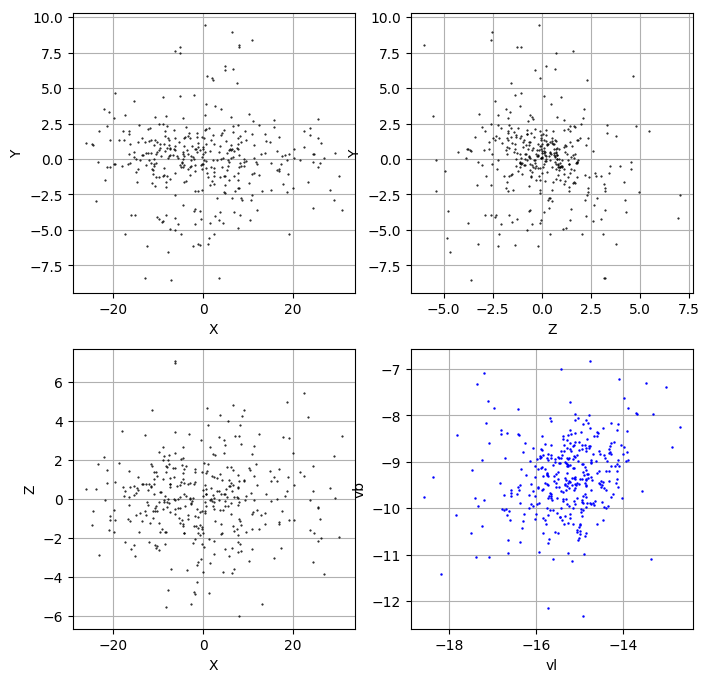

In [70]:
ocname= "NGC 2168-4.9deg-oc-mass.csv"
ocname= "NGC 2516-3.5deg-oc-mass.csv"
ocname= "NGC 1980-1.2deg-oc-mass.csv"
# ocname= "Collinder 419-1.0deg-oc-mass.csv"
# ocname= "NGC 6405-2.2deg-oc.csv"
# ocname= "NGC 6281-1.6deg-oc.csv"
# ocname= "FSR 1616-1.0deg-oc.csv"
ocname= "Alessi 62-1.4deg-oc.csv"
ocname= "NGC 2547-1.5deg-oc.csv"

oc= CSV.read("$ocdir/$ocname", delim= ";")

## plot the cluster
## OC recentered
oc.X= oc.X .- mean(oc.X)
oc.Y= oc.Y .- mean(oc.Y)
oc.Z= oc.Z .- mean(oc.Z)


fig= PyPlot.figure(figsize=(8,8))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
PyPlot.xlabel("X") ; PyPlot.ylabel("Z")
ax= PyPlot.subplot(224)
PyPlot.grid("on")
PyPlot.plot(oc.vl, oc.vb,"b.",markersize= 1.5 )
PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
PyPlot.show()

In [71]:
## functions

function create_graph_XV(oc, dmax, vmax)
    g = SimpleGraph()
    ndata= length(oc.ra)
    add_vertices!(g,ndata)
    
    A= Array{Float64}(undef,2,ndata)
    B= Array{Float64}(undef,2,ndata)
    for i in 1:ndata
        A[:,i]= [oc.Y[i] oc.Z[i]]
        B[:,i]= [oc.vl[i] oc.vb[i]]
    end

    d= Distances.Euclidean()
    Ax= Distances.pairwise(d, A, A, dims=2)
    Av=  Distances.pairwise(d, B, B, dims=2)
     
    for i in 1:ndata
        for j in 1:i-1
            if Ax[i,j] <= dmax && Av[i,j] <= vmax && i != j
                add_edge!(g, i,j)
            end
        end
    end
    
    return(g)
end


#### v: vertices
function plot_vert(v)
    fig= PyPlot.figure(figsize=(8,8))

    ax= PyPlot.subplot(221)
    PyPlot.grid("on")
    PyPlot.plot(oc.X, oc.Y,"k.",markersize=1)
    PyPlot.plot(oc.X[v], oc.Y[v],"r*",markersize=2)
    PyPlot.xlabel("X") ; PyPlot.ylabel("Y")
    ax= PyPlot.subplot(222)
    PyPlot.grid("on")
    PyPlot.plot(oc.Z, oc.Y,"k.", markersize=1)
    PyPlot.plot(oc.Z[v], oc.Y[v],"r*", markersize=2)
    PyPlot.xlabel("Z") ; PyPlot.ylabel("Y")
    ax= PyPlot.subplot(223)
    PyPlot.grid("on")
    PyPlot.plot(oc.X, oc.Z,"k.",markersize=1)
    PyPlot.plot(oc.X[v], oc.Z[v],"r*",markersize=2)
    PyPlot.xlabel("X") ; PyPlot.ylabel("Z")
    ax= PyPlot.subplot(224)
    PyPlot.grid("on")
    PyPlot.plot(oc.vl, oc.vb,"b.",markersize= 1. )
    PyPlot.plot(oc.vl[v], oc.vb[v],"rD",markersize= 2 )
    PyPlot.xlabel("vl") ; PyPlot.ylabel("vb")
    PyPlot.show()
    
end

plot_vert (generic function with 1 method)

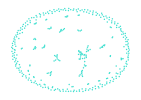

In [72]:
### MAIN
g= create_graph_XV(oc,0.5,0.5)
gplot(g)


In [73]:
# print(maximal_cliques(g))

for cl in maximal_cliques(g)
    if length(cl) > 2
        # println(cl)
    end
end

t= connected_components(g)
tmax=[]
for co in t
    if length(co) > length(tmax)
        tmax=co
    end
end
# println(tmax)

dd= degree(g)
# println(dd)


println(edges)
# plot_vert(tmax)

# println(degree(g))
# dh= degree_histogram(g)
# println(maximal_cliques(g))

# println(degree_centrality(g,normalize=true))



edges


In [74]:
nbin= 5
clmat= zeros(Float64, nbin, nbin)

dx= 1.0 / nbin ; dy= 1.0 / nbin
for i in 1:nbin
    for j in 1:nbin
        dm= dx*i
        dv= dy*j
        
        gi= create_graph_XV(oc,dm,dv)
        cli= maximal_cliques(gi)
        
        ccon= connected_components(gi)
        ncli= 0 ; nccon= 0
        for cl in cli
            if length(cl) > 2  ncli +=1 end
        end 
        for con in ccon
            if length(con) > 2  nccon +=1 end
        end
        
        if nccon==0 nccon=1 end
        clmat[i,j]= ncli/nccon
    end
end

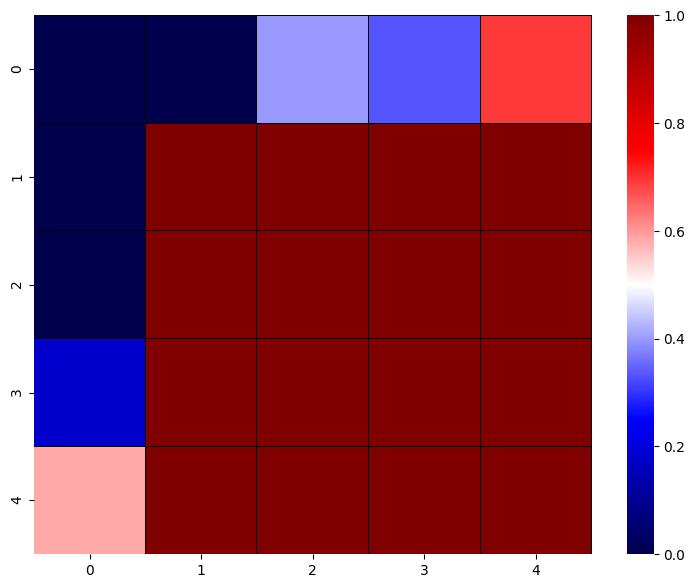

In [75]:
fig= PyPlot.figure(figsize=(9,7))
heat_map = sns.heatmap(clmat, vmin=0, vmax=1, cmap= "seismic",linewidths=0.1, 
    linecolor="black")
PyPlot.show()


In [76]:
## Zagreb-Randic indices
##

## first Zagreb index 
## Normalized here with vertex nmber
function _zagreb_first(g, α=2)   
    nvertex= nv(g)
    deg= degree(g)
    M1= sum(deg .^ α) / nvertex
    
    return(M1)
end


## second Zagreb index
## 
function _zagreb_second(g, α=1 ) 
    nvertex= nv(g)
    nedge= ne(g)
    edg= edges(g)
    
    M2= 0
    for e in edg
        d1= degree(g,src(e))
        d2= degree(g,dst(e))
        M2 += (d1*d2)^α
    end
    M2 /= nedge
    
    return(M2)
end

_zagreb_second (generic function with 2 methods)

In [77]:
## Zagreb

println("## First Zagreb index")
println(_zagreb_first(g,2))
    
println("## Second Zagreb index")
println(_zagreb_second(g,1))

## First Zagreb index
1.9619565217391304
## Second Zagreb index
8.036496350364963


## Loop on all OCs

In [78]:
cd(ocdir)
files= glob("*-oc.csv")
cd(wdir)

for f in files
    oc= CSV.read("$ocdir/$f" , delim= ";")
    
    println("## File: $f")
    g= create_graph_XV(oc,0.5,0.5)
    gplot(g)
    @printf("## First Zagreb index ; %3.3f \n", _zagreb_first(g,2))
    @printf("## Second Zagreb index ; %3.3f \n\n", _zagreb_second(g,1))
end


## File: ASCC 10-2.7deg-oc.csv
## First Zagreb index ; 0.857 
## Second Zagreb index ; 6.286 

## File: ASCC 100-1.8deg-oc.csv
## First Zagreb index ; 0.362 
## Second Zagreb index ; 3.000 

## File: ASCC 101-2.5deg-oc.csv
## First Zagreb index ; 0.509 
## Second Zagreb index ; 2.100 

## File: ASCC 103-1.4deg-oc.csv
## First Zagreb index ; 0.173 
## Second Zagreb index ; 1.250 

## File: ASCC 108-1.0deg-oc.csv
## First Zagreb index ; 0.026 
## Second Zagreb index ; 1.000 

## File: ASCC 11-2.0deg-oc.csv
## First Zagreb index ; 0.484 
## Second Zagreb index ; 3.667 

## File: ASCC 113-1.7deg-oc.csv
## First Zagreb index ; 0.277 
## Second Zagreb index ; 2.588 

## File: ASCC 114-1.0deg-oc.csv
## First Zagreb index ; 0.214 
## Second Zagreb index ; 2.250 

## File: ASCC 115-1.1deg-oc.csv
## First Zagreb index ; 0.111 
## Second Zagreb index ; 1.000 

## File: ASCC 118-1.0deg-oc.csv
## First Zagreb index ; 0.049 
## Second Zagreb index ; 1.250 

## File: ASCC 12-1.1deg-oc.csv
## First Za

## First Zagreb index ; 0.006 
## Second Zagreb index ; 1.000 

## File: Czernik 8-1.0deg-oc.csv
## First Zagreb index ; 0.020 
## Second Zagreb index ; 1.000 

## File: Czernik 9-1.0deg-oc.csv
## First Zagreb index ; 0.000 
## Second Zagreb index ; NaN 

## File: Dol-Dzim 4-1.0deg-oc.csv
## First Zagreb index ; 0.000 
## Second Zagreb index ; NaN 

## File: Dolidze 11-1.0deg-oc.csv
## First Zagreb index ; 0.060 
## Second Zagreb index ; 1.000 

## File: Dolidze 44-1.0deg-oc.csv
## First Zagreb index ; 0.060 
## Second Zagreb index ; 1.000 

## File: Dolidze 9-1.0deg-oc.csv
## First Zagreb index ; 0.041 
## Second Zagreb index ; 1.000 

## File: ESO 123-26-1.0deg-oc.csv
## First Zagreb index ; 1.701 
## Second Zagreb index ; 6.897 

## File: ESO 128-16-1.0deg-oc.csv
## First Zagreb index ; 0.034 
## Second Zagreb index ; 1.000 

## File: ESO 130-06-1.0deg-oc.csv
## First Zagreb index ; 0.082 
## Second Zagreb index ; 1.500 

## File: ESO 130-08-1.0deg-oc.csv
## First Zagreb index ; 0.1

## First Zagreb index ; 0.118 
## Second Zagreb index ; 1.763 

## File: FSR 1727-1.0deg-oc.csv
## First Zagreb index ; 0.343 
## Second Zagreb index ; 2.017 

## File: FSR 1728-1.0deg-oc.csv
## First Zagreb index ; 0.182 
## Second Zagreb index ; 1.000 

## File: FSR 1729-1.0deg-oc.csv
## First Zagreb index ; 0.109 
## Second Zagreb index ; 1.250 

## File: FSR 1739-1.0deg-oc.csv
## First Zagreb index ; 0.095 
## Second Zagreb index ; 1.667 

## File: FSR 1744-1.0deg-oc.csv
## First Zagreb index ; 0.031 
## Second Zagreb index ; 1.000 

## File: FSR 1750-1.0deg-oc.csv
## First Zagreb index ; 0.507 
## Second Zagreb index ; 2.714 

## File: Feinstein 1-1.0deg-oc.csv
## First Zagreb index ; 0.907 
## Second Zagreb index ; 4.008 

## File: Haffner 13-1.6deg-oc.csv
## First Zagreb index ; 0.363 
## Second Zagreb index ; 3.379 

## File: Harvard 16-1.0deg-oc.csv
## First Zagreb index ; 0.111 
## Second Zagreb index ; 1.333 

## File: Hogg 10-1.0deg-oc.csv
## First Zagreb index ; 0.080 
## 

## First Zagreb index ; 0.447 
## Second Zagreb index ; 2.488 

## File: NGC 7031-1.0deg-oc.csv
## First Zagreb index ; 0.095 
## Second Zagreb index ; 1.000 

## File: NGC 7062-1.0deg-oc.csv
## First Zagreb index ; 0.042 
## Second Zagreb index ; 1.000 

## File: NGC 7063-1.0deg-oc.csv
## First Zagreb index ; 0.484 
## Second Zagreb index ; 3.833 

## File: NGC 7082-1.6deg-oc.csv
## First Zagreb index ; 0.188 
## Second Zagreb index ; 1.118 

## File: NGC 7086-1.0deg-oc.csv
## First Zagreb index ; 0.260 
## Second Zagreb index ; 2.833 

## File: NGC 7092-4.5deg-oc.csv
## First Zagreb index ; 2.084 
## Second Zagreb index ; 7.342 

## File: NGC 7160-1.1deg-oc.csv
## First Zagreb index ; 0.044 
## Second Zagreb index ; 1.000 

## File: NGC 7209-1.2deg-oc.csv
## First Zagreb index ; 0.113 
## Second Zagreb index ; 1.250 

## File: NGC 7243-3.0deg-oc.csv
## First Zagreb index ; 0.191 
## Second Zagreb index ; 1.583 

## File: NGC 7281-1.0deg-oc.csv
## First Zagreb index ; 0.104 
## Second